In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import cv2

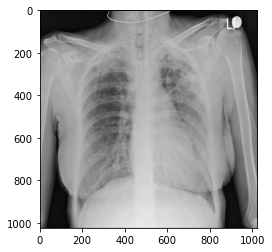

In [4]:
xray_one_image = Image.open("xray_one.png")
xray_one = np.asarray(xray_one_image)
plt.imshow(xray_one, cmap="gray", vmin=0, vmax=255)

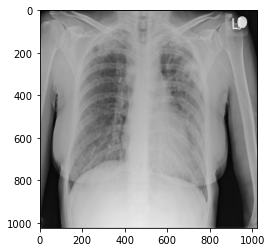

In [5]:
xray_two_image = Image.open("xray_two.png")
xray_two = np.asarray(xray_two_image)
plt.imshow(xray_two, cmap="gray", vmin=0, vmax=255)

# Defining Functions

In [6]:
def salt_and_pepper_noise(img):
  
    height , width = img.shape
    noisy_img = img.copy()
    
    
    def assign_noise_type(type):
        
        number_of_noisy_pixels = random.randint(10000, 100000)
        
        for i in range(number_of_noisy_pixels):

            y_coord=random.randint(0, height-1)
            x_coord=random.randint(0, width-1)
            noisy_img[y_coord][x_coord] = type
          
    assign_noise_type(255)
    assign_noise_type(0)
          
    return noisy_img

In [7]:
def gaussian_noise(img,sigma=1):
    noisy_img = img.copy()
    noise = np.random.normal(0,sigma,noisy_img.shape)
    noisy_img = noisy_img + noise
    return noisy_img

In [8]:
def filter_image(img, type='mean'):

    height, width = img.shape
    img_new = np.zeros([height, width])
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            kernel_values = []
            kernel_values.extend([img[i-1, j-1],img[i-1, j],img[i-1, j + 1],img[i, j-1],img[i, j],img[i, j + 1],img[i + 1, j-1],img[i + 1, j],img[i + 1, j + 1]])
            if type=='mean':
                temp = sum(kernel_values)/9
            elif type=='median':
                kernel_values.sort()
                temp = kernel_values[4]
            img_new[i, j]= temp
    return img_new

def gaussian_filter(img,shape=(3,3),sigma=0.5):
    m,n = [(ss-1.0)/2.0 for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    mask = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    mask[ mask < np.finfo(mask.dtype).eps*mask.max() ] = 0
    sumh = mask.sum()
    if sumh != 0:
        mask /= sumh
    height, width = img.shape    
    img_new = np.zeros([height, width])
        
    for i in range(1, height-1):
        for j in range(1, width-1):
            temp = img[i-1, j-1]*mask[0, 0]+img[i-1, j]*mask[0, 1]+img[i-1, j + 1]*mask[0, 2]+img[i, j-1]*mask[1, 0]+ img[i, j]*mask[1, 1]+img[i, j + 1]*mask[1, 2]+img[i + 1, j-1]*mask[2, 0]+img[i + 1, j]*mask[2, 1]+img[i + 1, j + 1]*mask[2, 2]
            img_new[i, j]= temp
    return img_new


In [9]:
def clahe(img,clipLimit,windowSize=32):
    height,width = img.shape
    uniquePixels = 256
    windowSizeX = 32
    windowSizeY = 32
    numberofWindowsX = np.ceil(height/windowSizeX).astype(int)
    numberofWindowsY = np.ceil(width/windowSizeY).astype(int)
        
    nrBins = 256
    windowPixels = windowSizeX*windowSizeY
    claheimg = np.zeros(img.shape)
    

    clipLimit = int(clipLimit*windowPixels/uniquePixels)
    
    
    

    histogramMatrix = np.zeros((numberofWindowsX, numberofWindowsY, 256))
    for i in range(numberofWindowsX):
        for j in range(numberofWindowsY):
            window = img[i*windowSizeX:(i+1)*windowSizeX, j*windowSizeY:(j+1)*windowSizeY].astype(int)
            for i1 in range(windowSizeX):
                for j1 in range(windowSizeY):
                    histogramMatrix[i,j,window[i1,j1]]+=1
    
    
    if clipLimit>0:
        for i in range(numberofWindowsX):
            for j in range(numberofWindowsY):
                excessPixels = 0
                for nr in range(256):
                    excess = histogramMatrix[i,j,nr] - clipLimit
                    if excess>0:
                        excessPixels += excess
                
                binIncr = excessPixels/nrBins
                upper = clipLimit - binIncr
                for nr in range(nrBins):
                    if histogramMatrix[i,j,nr] > clipLimit:
                        histogramMatrix[i,j,nr] = clipLimit
                    else:
                        if histogramMatrix[i,j,nr]>upper:
                            excessPixels += upper - histogramMatrix[i,j,nr]
                            histogramMatrix[i,j,nr] = clipLimit
                        else:
                            excessPixels -= binIncr
                            histogramMatrix[i,j,nr] += binIncr
                
                if excessPixels > 0:
                    stepSize = max(1,np.floor(1+excessPixels/256.0))
                    for nr in range(nrBins):
                        excessPixels -= stepSize
                        histogramMatrix[i,j,nr] += stepSize
                        if excessPixels < 1:
                            break
    
    
    mappedImage = np.zeros((numberofWindowsX,numberofWindowsY,256))
    scale = (255)/float(windowPixels)
    for i in range(numberofWindowsX):
        for j in range(numberofWindowsX):
            temp = 0
            for nr in range(256):
                temp += histogramMatrix[i,j,nr]
                mappedImage[i,j,nr] = np.floor(min(temp*scale,255))
    

    xI = 0
    for i in range(numberofWindowsX+1):
        if i==0:
            subX = int(windowSizeX/2)
            xU = 0
            xB = 0
        elif i==numberofWindowsX:
            subX = int(windowSizeX/2)
            xU = numberofWindowsX-1
            xB = numberofWindowsX-1
        else:
            subX = windowSizeX
            xU = i-1
            xB = i
        
        yI = 0
        for j in range(numberofWindowsY+1):
            if j==0:
                subY = int(windowSizeY/2)
                yL = 0
                yR = 0
            elif j==numberofWindowsY:
                subY = int(windowSizeY/2)
                yL = numberofWindowsY-1
                yR = numberofWindowsY-1
            else:
                subY = windowSizeY
                yL = j-1
                yR = j
            UL = mappedImage[xU,yL,:]
            UR = mappedImage[xU,yR,:]
            BL = mappedImage[xB,yL,:]
            BR = mappedImage[xB,yR,:]
            subBin = img[xI:xI+subX,yI:yI+subY]
            
            subImage = np.zeros(subBin.shape)
            num = subX*subY
            for i in range(subX):
                inverseI = subX-i
                for j in range(subY):
                    inverseJ = subY-j
                    val = subBin[i,j].astype(int)
                    subImage[i,j] = np.floor((inverseI*(inverseJ*UL[val] + j*UR[val])+ i*(inverseJ*BL[val] + j*BR[val]))/float(num))
            
            claheimg[xI:xI+subX,yI:yI+subY] = subImage
            yI += subY
        xI += subX
    
    
    return claheimg

In [10]:
def PSNR(original, processed):
    mse = np.mean((original - processed) ** 2)
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    print(psnr)

In [11]:
def plot_histogram(img, img1, img2):
    
    histogram = np.zeros(256)
    height, width = img.shape
    for i in range(height):
        for j in range(width):
            histogram[int(img[j,i])] += 1
    
    histogram1 = np.zeros(256)
    height, width = img1.shape
    for i in range(height):
        for j in range(width):
            histogram1[int(img1[j,i])] += 1
    
    histogram2 = np.zeros(256)
    height, width = img2.shape
    for i in range(height):
        for j in range(width):
            histogram2[int(img2[j,i])] += 1
    
    plt.plot(histogram, label = "original")
    plt.plot(histogram1, label = "noisy")
    plt.plot(histogram2, label = "enhanced")
    plt.legend()
    plt.show()

# Operations on Xray_one

### Adding Salt and Pepper Noise

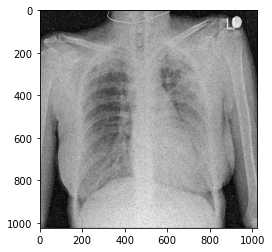

In [12]:
noisy_xray_one = salt_and_pepper_noise(xray_one)
plt.imshow(noisy_xray_one, cmap="gray", vmin=0, vmax=255)

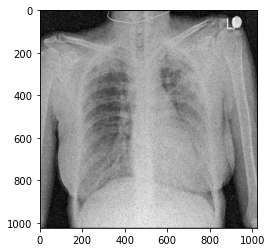

In [13]:
mean_filtered_xray = filter_image(noisy_xray_one, 'mean')
plt.imshow(mean_filtered_xray, cmap="gray", vmin=0, vmax=255)

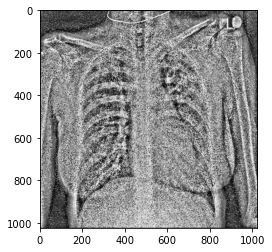

In [14]:
enhanced_mean_filtered_xray = clahe(mean_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_mean_filtered_xray, cmap="gray", vmin=0, vmax=255)

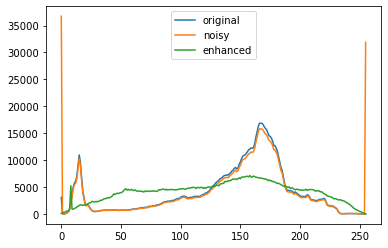

In [15]:
plot_histogram(xray_one, noisy_xray_one, enhanced_mean_filtered_xray)

In [16]:
PSNR(xray_one, enhanced_mean_filtered_xray)

13.101797846594561


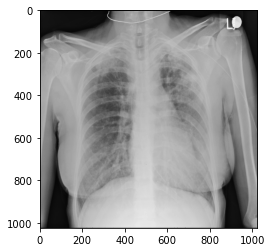

In [17]:
median_filtered_xray = filter_image(noisy_xray_one, 'median')
plt.imshow(median_filtered_xray, cmap="gray", vmin=0, vmax=255)

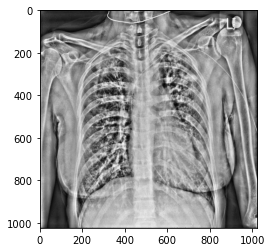

In [18]:
enhanced_median_filtered_xray = clahe(median_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_median_filtered_xray, cmap="gray", vmin=0, vmax=255)

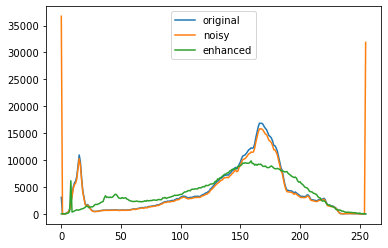

In [19]:
plot_histogram(xray_one, noisy_xray_one, enhanced_median_filtered_xray)

In [20]:
PSNR(xray_one, enhanced_median_filtered_xray)

17.992077736814103


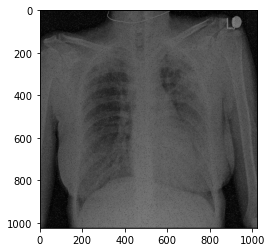

In [21]:
gauss_filtered_xray = gaussian_filter(noisy_xray_one, shape = (5,5), sigma=0.9)
plt.imshow(gauss_filtered_xray, cmap="gray", vmin=0, vmax=255)

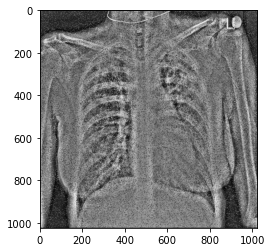

In [22]:
enhanced_gauss_filtered_xray = clahe(gauss_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_gauss_filtered_xray, cmap="gray", vmin=0, vmax=255)

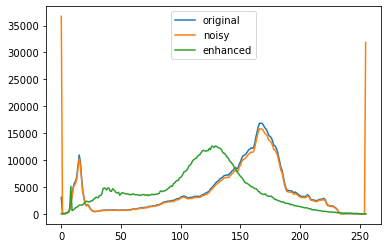

In [23]:
plot_histogram(xray_one, noisy_xray_one, enhanced_gauss_filtered_xray)

In [24]:
PSNR(xray_one, enhanced_gauss_filtered_xray)

12.98171567019487


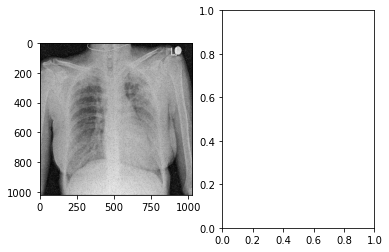

In [26]:
fig,axs = plt.subplots(1,2)
axs[0].imshow(noisy_xray_one,cmap='gray')
plt.show()

### Adding Gaussian Noise

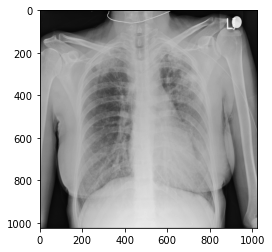

In [27]:
noisy_xray_one = gaussian_noise(xray_one,0.5)
plt.imshow(noisy_xray_one, cmap="gray", vmin=0, vmax=255)

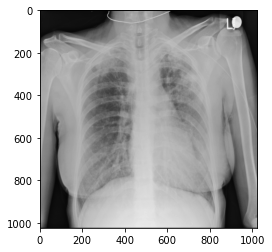

In [28]:
mean_filtered_xray = filter_image(noisy_xray_one, 'mean')
plt.imshow(mean_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [37]:
PSNR(xray_one, mean_filtered_xray)

34.58440506245868


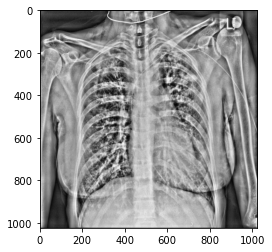

In [29]:
enhanced_mean_filtered_xray = clahe(mean_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_mean_filtered_xray, cmap="gray", vmin=0, vmax=255)

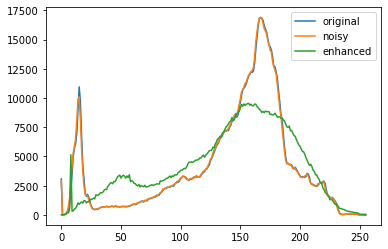

In [30]:
plot_histogram(xray_one, noisy_xray_one, enhanced_mean_filtered_xray)

In [31]:
PSNR(xray_one, enhanced_mean_filtered_xray)

17.8072169441701


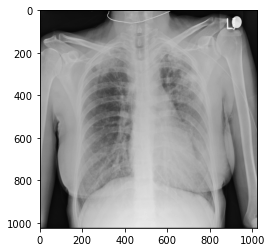

In [32]:
median_filtered_xray = filter_image(noisy_xray_one, 'median')
plt.imshow(median_filtered_xray, cmap="gray", vmin=0, vmax=255)

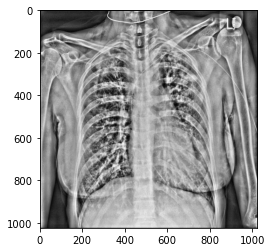

In [33]:
enhanced_median_filtered_xray = clahe(median_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_median_filtered_xray, cmap="gray", vmin=0, vmax=255)

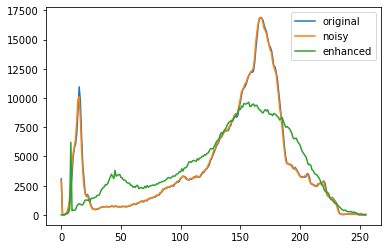

In [34]:
plot_histogram(xray_one, noisy_xray_one, enhanced_median_filtered_xray)

In [38]:
PSNR(xray_one,median_filtered_xray)

35.291968466252456


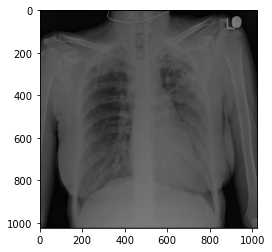

In [36]:
gauss_filtered_xray = gaussian_filter(noisy_xray_one, shape = (5,5), sigma=0.9)
plt.imshow(gauss_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
enhanced_gauss_filtered_xray = clahe(gauss_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_gauss_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
plot_histogram(xray_one, noisy_xray_one, enhanced_gauss_filtered_xray)

In [40]:
PSNR(xray_one, gauss_filtered_xray)

10.90143348034961


# Operations on Xray_two

In [ ]:
noisy_xray_two = salt_and_pepper_noise(xray_two)
plt.imshow(noisy_xray_two, cmap="gray", vmin=0, vmax=255)

In [ ]:
mean_filtered_xray = filter_image(noisy_xray_one, 'mean')
plt.imshow(mean_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
enhanced_mean_filtered_xray = clahe(mean_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_mean_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
plot_histogram(xray_two, noisy_xray_two, enhanced_mean_filtered_xray)

In [ ]:
PSNR(xray_two, enhanced_mean_filtered_xray)

In [ ]:
median_filtered_xray = filter_image(noisy_xray_two, 'median')
plt.imshow(median_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
enhanced_median_filtered_xray = clahe(median_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_median_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
plot_histogram(xray_two, noisy_xray_two, enhanced_median_filtered_xray)

In [ ]:
PSNR(xray_two, enhanced_median_filtered_xray)

In [ ]:
gauss_filtered_xray = gaussian_filter(noisy_xray_two, shape = (5,5), sigma=0.9)
plt.imshow(gauss_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
enhanced_gauss_filtered_xray = clahe(gauss_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_gauss_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
plot_histogram(xray_two, noisy_xray_two, enhanced_gauss_filtered_xray)

In [ ]:
PSNR(xray_two, enhanced_gauss_filtered_xray)

In [ ]:
noisy_xray_two = gaussian_noise(xray_two,0.5)
plt.imshow(noisy_xray_two, cmap="gray", vmin=0, vmax=255)

In [ ]:
mean_filtered_xray = filter_image(noisy_xray_one, 'mean')
plt.imshow(mean_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
enhanced_mean_filtered_xray = clahe(mean_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_mean_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
plot_histogram(xray_two, noisy_xray_two, enhanced_mean_filtered_xray)

In [ ]:
PSNR(xray_two, enhanced_mean_filtered_xray)

In [ ]:
median_filtered_xray = filter_image(noisy_xray_two, 'median')
plt.imshow(median_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
enhanced_median_filtered_xray = clahe(median_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_median_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
plot_histogram(xray_two, noisy_xray_two, enhanced_median_filtered_xray)

In [ ]:
PSNR(xray_two, enhanced_median_filtered_xray)

In [ ]:
gauss_filtered_xray = gaussian_filter(noisy_xray_two, shape = (5,5), sigma=0.9)
plt.imshow(gauss_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
enhanced_gauss_filtered_xray = clahe(gauss_filtered_xray,8,windowSize=32)
plt.imshow(enhanced_gauss_filtered_xray, cmap="gray", vmin=0, vmax=255)

In [ ]:
plot_histogram(xray_two, noisy_xray_two, enhanced_gauss_filtered_xray)

In [ ]:
PSNR(xray_two, enhanced_gauss_filtered_xray)